## Draft

## Bayesian Optimization

In [2]:
from bayes_opt import BayesianOptimization
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
from bokeh.palettes import all_palettes
from bokeh.models import ColumnDataSource
from bokeh.models import LinearColorMapper
from bokeh.palettes import Viridis3, Viridis256
output_notebook()

Loading BokehJS ...

In [3]:
def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

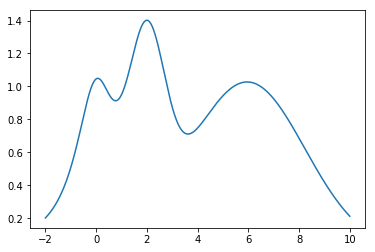

In [4]:
KAPPA = 5
x = np.linspace(-2, 10, 1000)
y = target(x)

plt.plot(x, y)


In [5]:
bo = BayesianOptimization(target, {'x': (-2, 10)})

In [6]:
bo.maximize(init_points=2, n_iter=3, acq='ucb', kappa=KAPPA)

Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |    1.16317 |    2.5690 | 
    2 | 00m00s |    0.92778 |    0.6133 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    3 | 00m02s |    0.21180 |   10.0000 | 
    4 | 00m02s |    1.02691 |    6.0117 | 
    5 | 00m05s |    0.20166 |   -2.0000 | 


In [7]:
print(bo.res['max'])
print(bo.res['all'])

{'max_val': 1.1631725311923191, 'max_params': {'x': 2.5689734050605644}}
{'values': [0.2117975080936653, 1.0269107794554981, 0.20166166980834865], 'params': [{'x': 10.0}, {'x': 6.011735529195493}, {'x': -2.0}]}


In [39]:
mean, sigma = bo.gp.predict(np.arange(4).reshape(-1, 1), return_std=True)

In [40]:
mean

array([0.78710999, 0.99943374, 1.12452944, 1.18014699])

In [77]:
mean.shape

(40,)

In [93]:
bo.maximize(init_points=2, n_iter=1, acq='ucb', kappa=KAPPA)

Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    8 | 00m02s |    1.31617 |    1.6742 | 


In [94]:
x = np.arange(-10, 10, .01)
y = target(x)
mean, s = bo.gp.predict(x.reshape(-1, 1), return_std=True)
s_upper = mean + s
s_lower = mean - s
x = np.hstack((x,x[::-1]))
y = np.hstack((y,y[::-1]))
sigma = np.hstack((s_upper, s_lower[::-1]))
mean = np.hstack((mean,mean[::-1]))
source = ColumnDataSource(dict(x=x, sigma=sigma, mean=mean, y=y))
plot = figure()
plot.patch(x='x', y='sigma',
            source=source, fill_color='lightgreen',
            line_color='green',
            line_width=1)
plot.line(x='x', y='mean', source=source)
plot.line(x='x', y='y', source=source, line_color='red')
handle = show(plot, notebook_handle=True)
